## 아래 링크에서 팀 쇠똥구리의 Data EDA 과정을 보실 수 있어요!

1. [Time-Related](https://nbviewer.jupyter.org/github/Seonu-Lim/Data-Science-for-COVID-19/blob/master/2%EC%B0%A8%EC%A0%9C%EC%B6%9C/COVID19-EDA-Visualization-ver-2-EDA-1-Time.ipynb)

2. [Region-Related](https://nbviewer.jupyter.org/github/Seonu-Lim/Data-Science-for-COVID-19/blob/master/2%EC%B0%A8%EC%A0%9C%EC%B6%9C/COVID19-EDA-Visualization-ver-2-EDA-2-Region.ipynb)

3. [Patient Related](https://nbviewer.jupyter.org/github/Seonu-Lim/Data-Science-for-COVID-19/blob/master/2%EC%B0%A8%EC%A0%9C%EC%B6%9C/COVID19-EDA-Visualization-ver-2-EDA-3-Patient.ipynb)

4. [EDA Summary](https://nbviewer.jupyter.org/github/Seonu-Lim/Data-Science-for-COVID-19/blob/master/2%EC%B0%A8%EC%A0%9C%EC%B6%9C/COVID19-EDA-Visualization-ver-2-Summary.ipynb)

## Data Preparation

In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import re
import sys
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib import animation, rc

import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import plotly.express as px
import folium
from folium import plugins
import branca
import json

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots


pio.renderers.default = "notebook_connected"

In [2]:
files = glob.glob('dataset/*.csv')
data = []
for i in files :
    i = re.sub("dataset/", "", i)
    data.append(re.sub(".csv","",i))
for i in range(len(files)) :
    globals()[data[i]] = pd.read_csv(files[i])

## 진짜 왜 20대가 많지?!!?!?? 편.  

  
  
저희 쇠똥구리 팀은 지난 EDA편에서 얻은 정보 중 의아한 부분을 발견할 수 있었습니다.

바로 COVID-19 확진자의 연령대 중 20대가 가장 많다는 점이었는데요.

아래 그래프를 살펴보시죠.

In [3]:
patientcount = PatientInfo.groupby('age').count().patient_id

fig = patientcount.iplot(asFigure=True, kind='bar')
fig.show()

확진자의 전체 연령대 분포를 살펴보면 20대가 가장 많은 것을 확인할 수 있네요!

이 사실은 상대적으로 건강하다고 여겨지는 20대가 COVID-19에 더 예방 및 면역력이 뛰어날 것이라는 생각에 배치되는 것이었습니다.

따라서 저희 팀은 **"20대 확진자의 비밀"**을 파헤쳐보고자 합니다!

비밀을 파헤치기 앞서, 20대와 20대 확진자의 속성부터 알아보도록 하죠.

In [4]:
population = pd.read_csv('custom_data/korea_2020_pop.csv',encoding='CP949')
population.columns = ['region','total','total2','0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','100s']
totalpop = population.iloc[0,[3,4,5,6,7,8,9,10,11,12,13]]

fig = totalpop.iplot(asFigure=True, kind='bar',color='firebrick')
fig.show()

**혹시 20대가 전체 인구 중 가장 많은 건 아니냐구요?**

이 질문에 답하기 위해 위해 행정안전부에서 전체 연령별 인구 데이터를 가져왔습니다.

위 plot에서 보여지는 대로 50대가 가장 많음을 확인할 수 있었습니다. 

그렇다면 어떤 속성이 20대 확진자를 증가시켰을까요?

저희 쇠똥구리 팀은 다음 3가지 가설을 확인해보기로 했습니다.

* **1. 20대가 많이 돌아다녔기 때문이다?! (유동 인구)**


* **2. 20대가 사람들이 많은 곳에 자주 간다?! (접촉자 수)**


* **3. 대구/경북 지역에 20대가 많이 산다?! (20대 인구 분포)**

## 1.  20대가 많이 돌아다녔기 때문이다?!

먼저 첫 번째 가설부터 살펴보죠.

유동인구 데이터입니다.

In [5]:
SeoulFloating['hour'] = pd.TimedeltaIndex(SeoulFloating.hour,unit='H')
SeoulFloating['datehour'] = pd.to_datetime(SeoulFloating['date'] )+ SeoulFloating['hour']
SeoulFloating[SeoulFloating.datehour == '2020-02-22 23:00'].fp_num
temp = SeoulFloating[SeoulFloating.date == '2020-02-23'].fp_num/2
SFedit = SeoulFloating
SFedit.loc[SFedit.date == '2020-02-23','fp_num'] = temp
temp2 = SeoulFloating[SeoulFloating.datehour == '2020-02-23 11:00:00'].fp_num *2
SFedit.loc[SFedit.datehour == '2020-02-23 11:00:00','fp_num'] = temp2

In [6]:
birthsum = SFedit.groupby('birth_year').sum()
fig = birthsum.iplot(asFigure=True, kind='bar', color="royalblue")
fig.show()

이럴수가!

**20대보다 30~50대의 유동인구가 더 많네요.**

첫 번째 가설도 20대 확진자의 비밀은 아니었습니다.

바로 두 번째 가설을 살펴보겠습니다.

## 2. 20대가 사람들이 많은 곳에 자주 간다?!

저희 쇠똥구리 팀은 "사람들이 많은 곳에 자주 간다 = 평균 접촉자 수가 많다" 라고 판단했습니다.

이에 COVID-19 확진자의 평균 접촉자 수를 나타낸 그래프를 살펴보겠습니다.

In [7]:
agecontact = PatientInfo.groupby('age').mean().contact_number
fig = agecontact.iplot(asFigure=True, kind='bar')
fig.show()

10대가 평균 접촉자 수가 월등히 높게 나타납니다!

하지만 언제나 평균에는 Outlier라는 함정이 있죠! 

10대가 월등히 높은 이유는 10대 확진자 중 한명이 1000명 넘는 접촉자를 가지고 있기 때문입니다.

10대의 확진자 수가 적은 것도 평균을 높인 이유가 되겠네요.

따라서 10대를 빼고 살펴보는 것이 타당할 것 같습니다.

10대를 빼고 봐도 **20대는 접촉자 수가 그렇게 많진 않네요.** 오히려 60대의 접촉자 수가 많아요! 

아쉽게도 2번째 가설도 비밀이 아니었습니다.

3번째 가설은 어떨까요??

## 3. 대구/경북 지역에 20대가 많이 산다?!

그렇다면 전국에서 확진자가 가장 많이 발생한 대구/경북 지역에 20대가 상대적으로 많은 것은 아닐까요?

전국 20대 분포 지도를 살펴보겠습니다.

In [8]:
korea = gpd.read_file("korea")

In [9]:
korea.CTP_ENG_NM[korea.CTP_ENG_NM == 'Jellanam-do'] = 'Jeollanam-do'

In [10]:
twtregion = population.loc[:,['region','20s']]
twtregion = twtregion.drop(0)
twtregion = twtregion.set_index('region')
twtregion.rename(index = {'서울특별시  (1100000000)' : 'Seoul', 
                           '부산광역시  (2600000000)' : 'Busan',
                           '대구광역시  (2700000000)' : 'Daegu',
                           '인천광역시  (2800000000)' : 'Incheon',
                           '광주광역시  (2900000000)' : 'Gwangju',
                           '대전광역시  (3000000000)' : 'Daejeon',
                           '울산광역시  (3100000000)' : 'Ulsan',
                           '세종특별자치시  (3600000000)' : 'Sejong-si',
                           '경기도  (4100000000)' : 'Gyeonggi-do',
                           '강원도  (4200000000)' : 'Gangwon-do',
                           '충청북도  (4300000000)' : 'Chungcheongbuk-do',
                           '충청남도  (4400000000)' : 'Chungcheongnam-do',
                           '전라북도  (4500000000)' : 'Jeollabuk-do',
                           '전라남도  (4600000000)' : 'Jeollanam-do',
                           '경상북도  (4700000000)' : 'Gyeongsangbuk-do',
                           '경상남도  (4800000000)' : 'Gyeongsangnam-do',
                           '제주특별자치도  (5000000000)' : 'Jeju-do'} , inplace = True)

twtregion["CTP_ENG_NM"] = list(twtregion.index) 
twtregion['20s'] = twtregion['20s'].str.replace(',', '').astype('int64')

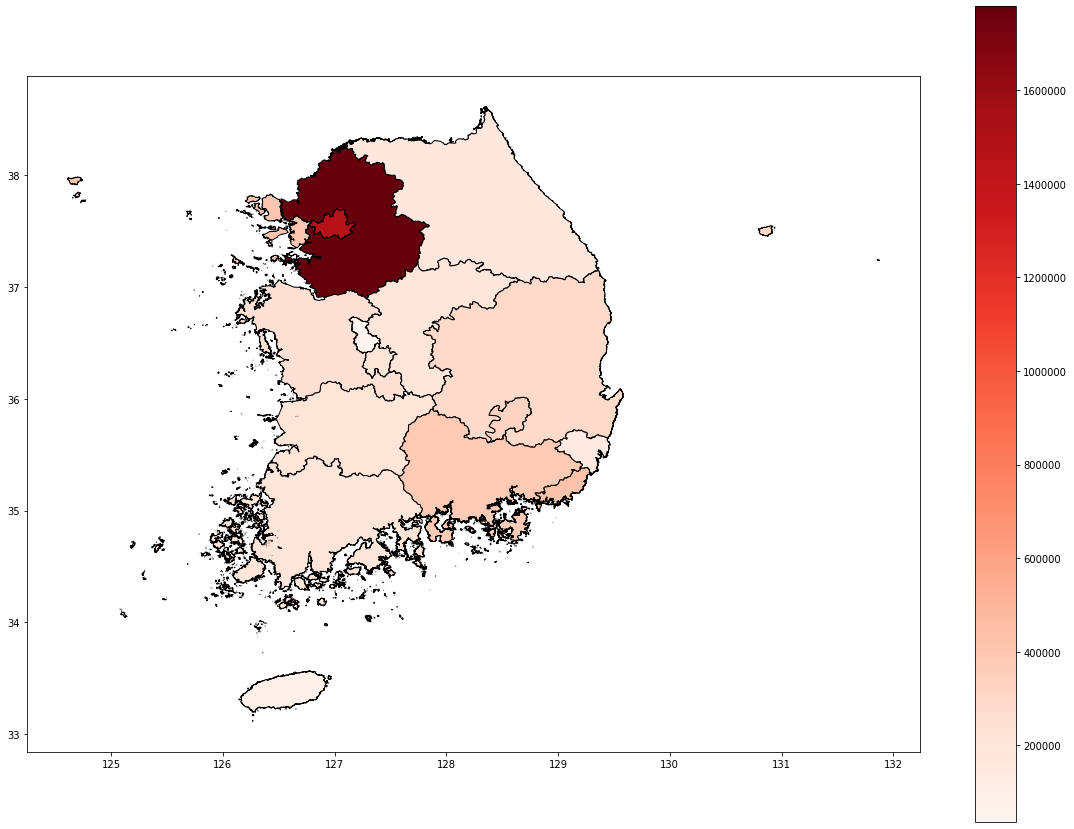

In [11]:
merge = pd.merge(korea, twtregion, how='left', on=['CTP_ENG_NM'])
merge.plot(column='20s',legend=True, cmap="Reds",edgecolor="black",figsize=(20,15))

In [12]:
fig = twtregion.iplot(asFigure=True,kind='bar', color = "#7201a8")
fig.show()

"전국 20대 분포 지도"와 "시도별 인구 현황 그래프"입니다.

**서울, 경기 지역에 20대가 제일 많아요.** 

아래에서 보듯이 확진자 수는 대구에 제일 많은데 말이에요.

In [13]:
TP = TimeProvince[TimeProvince.date=='2020-04-20'].drop(['released','deceased','time','date'],axis=1)
regionconf = TP.set_index('province')
fig = regionconf.iplot(asFigure=True,kind='bar',color="#0d0887")
fig.show()

그렇다면, 20대 확진자는 어느 지역에 가장 많을까요??

In [14]:
twtinfo = PatientInfo[PatientInfo.age == '20s']
twtinforeg = pd.DataFrame(twtinfo.groupby('province').count().patient_id)
twtinforeg["CTP_ENG_NM"] = list(twtinforeg.index) 

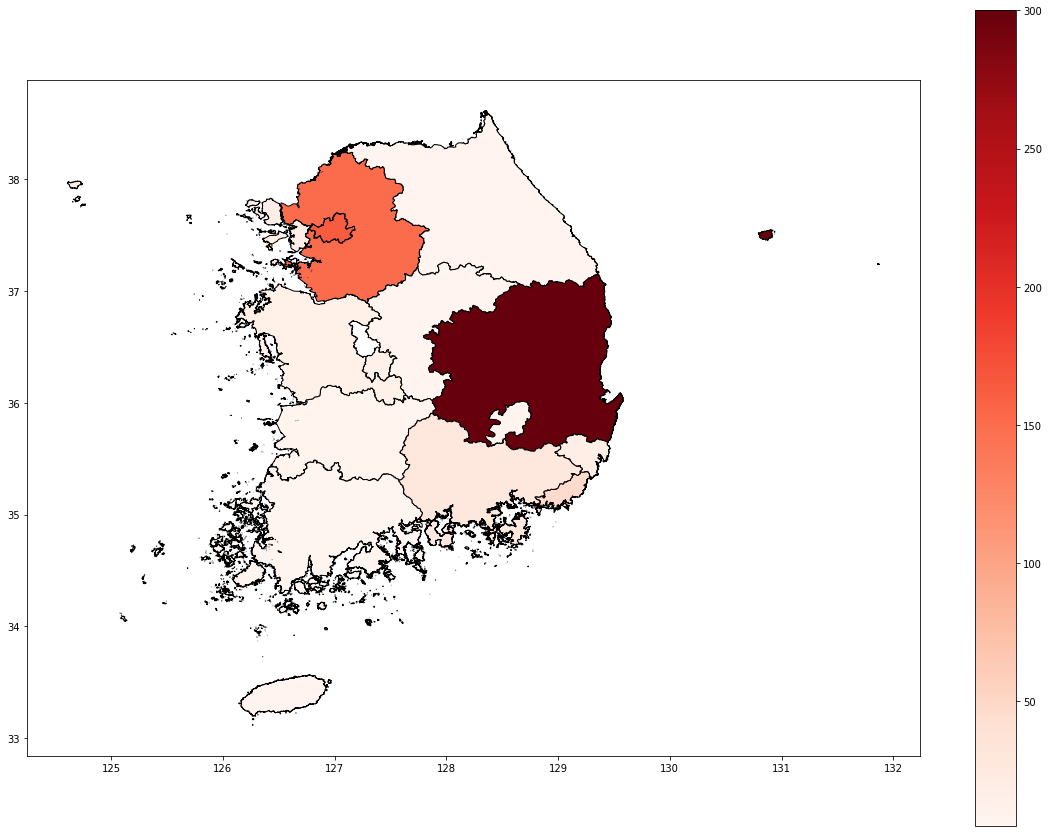

In [15]:
merge2 = pd.merge(korea, twtinforeg, how='left', on=['CTP_ENG_NM'])
merge2.plot(column='patient_id',legend=True, cmap="Reds",edgecolor="black",figsize=(20,15))

In [16]:
fig = twtinforeg.iplot(asFigure=True,kind='bar',color="#9c179e")
fig.show()

아니 이럴수가! 경상북도에 20대 확진자가 정말 많아요! 

그리고 그 다음으로 서울이랑 경기도에 많구요. 서울이랑 경기도에 20대 확진자가 많은 건 아무래도 그 두 지역에 20대가 많기 때문이겠죠.

도대체 **경상북도에 20대 코로나 환자가 왜 그렇게 많아진걸까요?!** 

# 2020.05.06 내용 추가

이번 제출의 내용은 아래와 같습니다.

1. 경상북도의 20대 확진자가 많았던 원인
2. 20대 확진자의 infection case
3. 20대 확진자의 PatientRoute

그럼 먼저...

## 1. 경상북도의 20대 확진자에 대해 알아봅시다.

대구가 아닌 **경상북도에 20대 확진자가 월등히 많았다**는 것을 알아버린 쇠똥구리팀은 충격을 받고, 우선은 경상북도만 떼어내서 다시 분석을 해보았어요.

In [17]:
PatientInfo_gb = PatientInfo[PatientInfo.province == 'Gyeongsangbuk-do']

In [18]:
total = gpd.read_file("total")
gb = total[total.CTP_ENG_NM == "Gyeongsangbuk-do"]

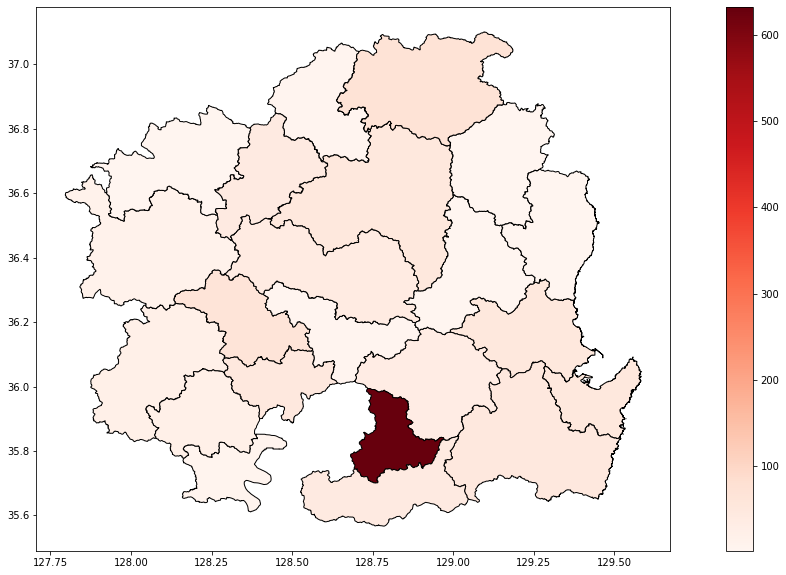

In [19]:
all_city = pd.DataFrame(PatientInfo_gb.groupby('city').count().patient_id)
all_city["SIG_ENG_NM"] = list(all_city.index) 

merge_gb = pd.merge(gb, all_city, how='left', on=['SIG_ENG_NM'])
merge_gb.plot(column='patient_id',legend=True, cmap="Reds",edgecolor="black",figsize=(20,10))

전체 연령대의 확진자 수로 살펴보면, 대구와 인접해있는 **경산시**의 확진자 수가 가장 많았습니다. 대구와 인접해 있었기 때문에 경상북도에서 확진자 수가 가장 많았을 수밖에 없네요. **(참고 : 맨 위에 있는 링크들 중, Summary에 들어가셔서 시간에 따른 Patient Route 를 영상으로 확인해 보세요!)**

그럼 20대는 어땠을까요?

In [20]:
twt_GyungBook = twtinfo[twtinfo.province == 'Gyeongsangbuk-do']

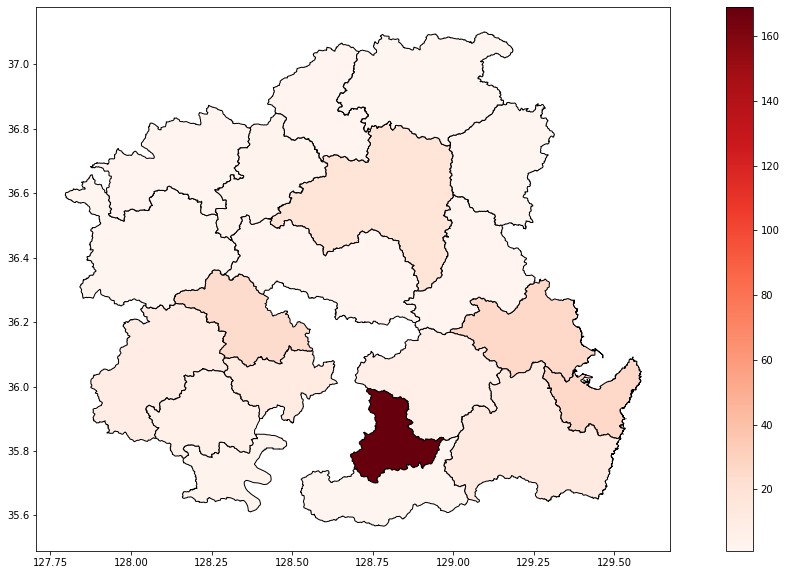

In [21]:
twt_city = pd.DataFrame(twt_GyungBook.groupby('city').count().patient_id)
twt_city["SIG_ENG_NM"] = list(twt_city.index) 

merge_gb = pd.merge(gb, twt_city, how='left', on=['SIG_ENG_NM'])
merge_gb.plot(column='patient_id',legend=True, cmap="Reds",edgecolor="black",figsize=(20,10))

20대 역시 경산시에 가장 많이 분포해있었습니다. 즉, 경산시의 확진자 인구가 많았기 때문에 경상북도의 확진자 인구가 많아졌던 것이고, 이는 특히 경산시의 20대 확진자가 많아서라고 할 수 있겠습니다. 왜 경산시의 20대 확진자가 유난히 많은 것일까요?

In [22]:
PatientInfo_gb = PatientInfo_gb[PatientInfo_gb.city == 'Gyeongsan-si']
PatientInfo_gb.infection_case.value_counts()

etc                                      65
Gyeongsan Seorin Nursing Home            15
Gyeongsan Jeil Silver Town               12
Gyeongsan Cham Joeun Community Center    10
Shincheonji Church                        2
overseas inflow                           1
Name: infection_case, dtype: int64

In [23]:
PatientInfo_gb[PatientInfo_gb.age =='20s'].infection_case.value_counts()

etc                   1
Shincheonji Church    1
Name: infection_case, dtype: int64

안타깝게도 NA 가 너무 많아서 극히 일부만 infection case 를 확인할 수 있었습니다..ㅠㅠ 특히, 경산시 20대의 infection case는 위에서 본 것처럼 기타 1개, 그리고 신천지 1개, 그 외에는 NA 값이라서 어떤 감염케이스인지 전혀 알 수가 없었답니다. 결국 데이터에서 찾을 수는 없고, 추측만 가능하다는 거겠죠. 우선 경산시에 대한 분석은 미뤄두고, 다시 전국의 20대 확진자로 돌아가 infection case 를 봅시다. 

## 2. 20대의 Infection Case 에 주목하자

전국의 20대 감염자들의 infection case 는 어땠을까요? 그리고 다른 나이대와 비교했을 때 어떻게 달랐을까요?

In [24]:
twtinfo['infection_case'] = twtinfo['infection_case'].fillna("NA")
twtinfo = twtinfo.sort_values(by=['confirmed_date'], axis=0)
counts = pd.get_dummies(twtinfo['infection_case']).cumsum()
counts = twtinfo[["confirmed_date","infection_case"]].join(counts)

counts["summary_infect"] = [ list(counts[list(counts.infection_case)[i]])[i] for i in range(0, len(counts)) ]
counts = counts.drop_duplicates(["confirmed_date","infection_case"], keep="last")
counts = counts.sort_values(by=['confirmed_date'], axis=0)

In [25]:
fig = go.Figure()
fig = px.line(counts, x='confirmed_date', y='summary_infect',
              color="infection_case",
              line_group="infection_case", hover_name="infection_case")
fig.update_layout(title='20s infection_case' , showlegend=True)

fig.show()

20대 확진자의 경우 **overseas inflow**의 누적 확진자 수가 가장 많았고, 그 다음은 감염 원인을 공개하지 않은 NA가 많았습니다. 이 둘과 상당한 차이를 두고 **contact with patient**가 3번째로 많은 원인이었네요. 그 아래는 다시 원인이 불분명한 etc였고요. 20대를 제외한 나머지 나이대로 똑같은 그래프를 그려서 비교해 봅시다.

In [26]:
nottwtinfo = PatientInfo[PatientInfo.age != '20s']
nottwtinfo['infection_case'] = nottwtinfo['infection_case'].fillna("NA")

In [27]:
nottwtinfo = nottwtinfo.sort_values(by=['confirmed_date'], axis=0)
counts = pd.get_dummies(nottwtinfo['infection_case']).cumsum()
counts = nottwtinfo[["confirmed_date","infection_case"]].join(counts)

counts["summary_infect"] = [ list(counts[list(counts.infection_case)[i]])[i] for i in range(0, len(counts)) ]
counts = counts.drop_duplicates(["confirmed_date","infection_case"], keep="last")
counts = counts.sort_values(by=['confirmed_date'], axis=0)

In [28]:
fig = go.Figure()
fig = px.line(counts, x='confirmed_date', y='summary_infect',
              color="infection_case",
              line_group="infection_case", hover_name="infection_case")
fig.update_layout(title='All age except 20s infection_case' , showlegend=True)

fig.show()

20대를 제외한 나이대를 보았을 때 **contact with patient 의 증가세가 훨씬 두드러졌습니다.** 누적 확진자 수가 가장 많아요! 결국 20대는 감염자와의 접촉이 가장 큰 원인이 아니었던 거예요. 이쯤되면 20대에게 '코로나에 대해 경각심이 부족하다'고 말할 수 있는 건지 의구심이 듭니다.

한편, 20대를 비롯하여 infection_case가 NA인 데이터가 2월말~3월초에 월등히 많았는데, NA가 급격히 증가했던 기간의 정부 브리핑 자료로 미루어 보았을 때 **신천지에 의한 감염**일 가능성이 높다고 여겨졌습니다. 그렇다면, 신천지를 제외한 감염자들의 연령대 분포는 어땠을까요? 감염자들의 infection case 중 NA와 infection case 를 제외하고 다시 연령대 분포 그래프를 그려보았습니다.

### 신천지가 아닌 감염자들의 연령대별 분포

In [29]:
PatientInfo['infection_case'] = PatientInfo['infection_case'].fillna("NA")
PatientInfo_NoShin = PatientInfo[PatientInfo.infection_case != 'NA']
PatientInfo_NoShin = PatientInfo_NoShin[PatientInfo_NoShin.infection_case != "Shincheonji Church"]

PatientInfo_NoShin_count = PatientInfo_NoShin.groupby('age').count().patient_id

fig = PatientInfo_NoShin_count.iplot(asFigure=True, kind='bar')
fig.show()

신천지의 영향이 완전히 제거되었다고는 할 수 없겠지만, 신천지라고 알려져 있거나 추정되는 사람들을 모두 제거하였음에도 불구하고 20대 감염자 수는 다른 연령대에 비해 많았습니다. 

지금까지 쇠똥구리가 새롭게 알아낸 20대 확진자의 급증 원인은 아래와 같습니다.

1. 해외유입
2. 경상북도 경산시

음, 혹시 다른 원인들이 있을까요? 20대 확진자들의 이동 경로에 또 다른 해답이 있진 않을까요?

- - - 
**cf)** 20대들의 해외유입에 관하여! \
(아래 주장은 확실하게 세팅된 자료가 아닌 단순 비교로 이런 것도 있을 수 있겠다~ 하는 가벼운 마음으로 읽어주시면 감사하겠습니다.)

**20대 확진자 중 해외유입이 많은 이유는 유학생이 많기 때문이다??**

20대의 해외유입 사유 확진자가 많은 원인에 새로운 측면을 생각해보았습니다!
20대는 학위, 어학 연수 등의 사유로 해외 출국이 가장 많을 연령대라 생각합니다.
이에 해외여행 뿐 아니라 유학생의 비중이 20대에 높은 것이 해외 유입이 많은 이유일 가능성도 있을까요?
단순 비율 비교로 살펴보겠습니다.

1. 20대 전체 인구 중 20대 확진자 비율
802 / 6,823,973 = **약 0.01** %

2. 국외 한국인 대학 학위과정 유학생(20대가 대부분이라 가정, 전부 20대는 아님) 과 20대 해외유입 확진자 비율
243 / 123,795 = **약 20 %** \
(출처: 한국은행 경제통계시스템 2018년 기준)

가정이 많이 포함된 자료로 확실한 비교는 어렵지만 
전체 20대 인구 대비 확진자 비율보다도 국외 한국인 유학생 대비 20대 해외유입 확진자 비율이 높습니다.
물론 정확하지 않은 비교입니다만 새로운 시각을 갖게 한다는 점에서 의의가 있을 것 같습니다.
- - - 

## 3. 20대 감염자들은 어디를 돌아다녔을까?

20대 확진자들의 이동 경로를 보기 전에, 우선 전체 연령대에 대해서는 어떨지 봅시다.

In [30]:
places = PatientRoute.type.unique()
simproute = PatientRoute[['patient_id','date','type']]
agedf = PatientInfo[['patient_id','age']]
simproutewage = pd.merge(simproute,agedf,how='left')
fiplot = simproutewage.set_index('type')
fiplot_count = fiplot.groupby('type').count().patient_id.sort_values()

In [31]:
fig = fiplot_count.iplot(asFigure = True, kind='bar')
fig.show()

etc와 hospital이 월등히 많네요. etc는 내용이 불분명하니 일단 미뤄두고, hospital은 감염자들이 최소 한번은 갈 장소이기 때문에 많은 것이 당연해요. 따라서 etc와 hospital을 지우고 위 내용을 20대와 20대가 아닌 나이대로 나누어서 다시 그래프를 그려보았습니다.

In [32]:
twtfi = fiplot[fiplot.age == '20s']
untwtfi = fiplot[fiplot.age != '20s']
twt = twtfi.groupby('type').count().patient_id
untwt = untwtfi.groupby('type').count().patient_id
twt = twt[~twt.index.isin( ['etc','hospital'])]
untwt = untwt[~untwt.index.isin( ['etc','hospital'])]
fig = go.Figure()
fig.add_trace(go.Bar(x = twt.index, 
                     y = twt,
                     name = '20대',
                     marker_color='indianred'))
fig.add_trace(go.Bar(x = untwt.index, 
                     y = untwt,
                     name = '20대 아닌 나이대',
                     marker_color='lightsalmon'))
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

이 그래프에서, 우리는 20대가 다른 나이대에 비해 더 많이 간 장소들을 확인할 수 있습니다. 

* **1. academy, bar, university, cafe, pc_cafe 의 경우 다른 나이대의 확진자를 모두 합친 것보다 20대 확진자가 더 많이 갔습니다.**
* **2. airport, church, public_transportation, gym 은 20대 아닌 나이대의 절반이 넘는 20대 확진자가 갔습니다.**
* **3. 반대로, pharmacy, real_estate_agency, school, beauty salon 은 다른 확진자들에 비해 20대 확진자 수가 적습니다.**

Airport가 많았던 것은 위에서 보았듯 infection_case 가 overseas 인 사람들이 필연적으로 거쳐야 하는 장소가 공항이기 때문이겠죠. 20대는 다른 나이대와 달리 overseas infection이 많았기 때문에 당연한 결과일 것입니다.

여기서 주목할 것은 학원이나 PC방, 대중교통, 체육관, 종교시설 등 **누가 봐도 사회적 거리두기가 쉽지 않을 것 같은 곳**에 20대가 유난히 많았다는 점입니다.  어쩌면 여기에 20대 확진자가 많았던 원인이 있었던 게 아니었을까요?